In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
# Loading data

#centroid_locations = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/CensusTractCentroids.csv")
#metro_locations = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/MetroLinkStations_REGISTERED.csv")
#census_data = data = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/B08119_stl_city.csv")

centroid_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_REGISTERED.csv")
census_data = data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08119_stl_city.csv")

# eventually, get the number of people taking public transportation in each tract to weight the nearest neighbor calculation

In [9]:
# Working with census data

warnings. filterwarnings('ignore')

# Only keep important columns
census_data = census_data[['location','label','estimate','moe']]
census_data['label'] = census_data['label'].str.replace('Estimate', '').str.replace('Total', '').str.replace('!!', '').str.replace(':', '')
census_data['location'] = census_data['location'].str.replace('; St. Louis city; Missouri','')

# Filter out aggregate columns
all_totals = census_data[census_data['label']=='']
trans_totals_mask = ~census_data['label'].astype(str).str.contains('[$]')
trans_totals = census_data.loc[trans_totals_mask][1:]
income_totals = census_data[census_data['label'].str.startswith("$")]
not_to_include = pd.concat([trans_totals, income_totals, all_totals])
merged_df = pd.merge(census_data, not_to_include, how='left', indicator=True)
no_totals = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])[1:]
split_data = no_totals['label'].str.split('$', 1, expand=True)
no_totals[['transportation', 'income']] = split_data
no_totals.drop(columns=['label'], inplace=True)
no_totals['income'] = '$' + no_totals['income']
from_this = no_totals['income'].unique()
to_this = [1, 10000, 15000, 25000, 35000, 50000, 65000, 75000]
no_totals['avg income'] = no_totals['income'].replace(from_this, to_this)
clean_census_data = no_totals

# Group by census tract and mode of transportation
by_tract_trans = clean_census_data.groupby(['location','transportation'])['estimate'].sum()

# Find percentage of people who take public transport in each tract
tract_pops = clean_census_data.groupby('location', as_index = False)['estimate'].sum()['estimate'].tolist()
public_transit_pops = clean_census_data[clean_census_data['transportation']=='Public transportation (excluding taxicab)'].groupby(['location','transportation'], as_index = False)['estimate'].sum()['estimate'].tolist()

pct_public_trans = []
for i in range(len(tract_pops)):
    pct_public_trans.append(public_transit_pops[i]/tract_pops[i])

# Add percentages back in to groupby
percent_by_tract = clean_census_data.groupby('location', as_index = False)['estimate'].sum()
percent_by_tract['public transport %'] = pct_public_trans

    
percent_by_tract.head()

,location,estimate,public transport %
0,Census Tract 1011,1039,0.029836
1,Census Tract 1012,1921,0.005726
2,Census Tract 1013,2161,0.016196
3,Census Tract 1014,1502,0.063249
4,Census Tract 1015,1318,0.024279


In [4]:
# Unweighted sum of distances from each census tract centroid to nearest metro stop in lat/lon units

def dist_to_nearest_stop(centroid_locations, metro_locations):
    closest_metro_loc = np.zeros([len(centroid_locations), 2]) # latitude and longitude
    closest_metro_id = np.zeros(len(centroid_locations))
    shortest_distance = np.zeros(len(centroid_locations))
    
    for i in range(len(centroid_locations)):
        cent = np.array([centroid_locations.INTPTLAT[i],centroid_locations.INTPTLON[i]])
        closest_distance = float('inf') # initialize to infinity
        for j in range(len(metro_locations)):
            metro = np.array([metro_locations.Y[j],metro_locations.X[j]])
            distance = np.linalg.norm(cent-metro)
            if (distance < closest_distance):
                closest_distance = distance
                closest_metro_loc[i,0] = metro[0]
                closest_metro_loc[i,1] = metro[1]
                closest_metro_id[i] = metro_locations.StopID[j]
        shortest_distance[i] = closest_distance
    
    return closest_metro_loc, closest_metro_id, shortest_distance

In [5]:
closest_metro_loc, closest_metro_id, shortest_distance = dist_to_nearest_stop(centroid_locations, metro_locations)

values, counts = np.unique(closest_metro_id, return_counts=True)
for i in range(len(values)):
    name = metro_locations['StopAbbr'][metro_locations['StopID'] == values[i]].tolist()[0]
    print(f'Stop {values[i]}, {name}, is closest for {counts[i]} census tracts')

Stop 10619.0, CONVST, is closest for 5 census tracts
Stop 10622.0, CVCNST, is closest for 3 census tracts
Stop 10623.0, UNSTST, is closest for 7 census tracts
Stop 10624.0, GRNDST, is closest for 23 census tracts
Stop 10625.0, CWTCST, is closest for 7 census tracts
Stop 10626.0, FOPKST, is closest for 8 census tracts
Stop 10627.0, DLMRST, is closest for 1 census tracts
Stop 10628.0, WELLST, is closest for 4 census tracts
Stop 10629.0, RKRDST, is closest for 4 census tracts
Stop 10630.0, UMSOST, is closest for 4 census tracts
Stop 13662.0, STADST, is closest for 1 census tracts
Stop 14753.0, SHRBST, is closest for 19 census tracts
Stop 14754.0, SUNNST, is closest for 1 census tracts
Stop 14761.0, SKBLST, is closest for 2 census tracts
Stop 16149.0, CRTXST, is closest for 15 census tracts


In [6]:
nn_score = np.sum(shortest_distance)
print(f'Score (sum of all shortest distances): {nn_score:0.4f}')

Score (sum of all shortest distances): 3.3242


Text(0.5, 1.0, 'Histogram of distances to closest metro stops')

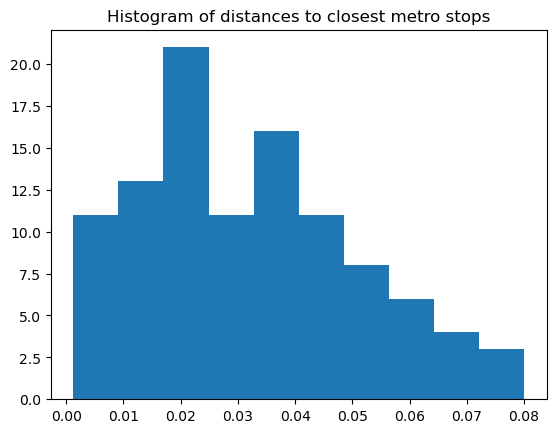

In [7]:
plt.hist(shortest_distance)
plt.title('Histogram of distances to closest metro stops')